# Housing linear regression
### Hyperparameters of the linear regression model:
* Since it is linear regression, the network is already defined as a 1 neuron combining all the features of the input in a linear way so layer number and number of units are not hyperparameters in this specific problem.
* Regularization type, and term is a hyper parameter to be tuned(We will find that we need to use regularization due to overfitting).
* The type of optimizer and its parameters.
* Learning rate (We will need to tune it so we reach convergence).
* Loss function.


In [0]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib

import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats.stats import pearsonr
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1
from keras.optimizers import Adam,SGD
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [0]:
%config InlineBackend.figure_format = 'png' #set 'png' here when working on notebook
%matplotlib inline

In [0]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

In [0]:
train["SalePrice"] = np.log1p(train["SalePrice"])
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index
skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

all_data = pd.get_dummies(all_data)

all_data = all_data.fillna(all_data.mean())

X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

X_train = StandardScaler().fit_transform(X_train)

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y, random_state = 3)

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [0]:
def test_model(loss, opt, reg, X_tr, y_tr, X_val, y_val):  
  #START CODE HERE
  def Model(input_shape, reg=None):
    model = Sequential()
    model.add(Dense(1, input_shape = input_shape, kernel_regularizer = reg))
    return model;
  model = Model(X_tr.shape[1:], reg)
  #END CODE HERE
  model.compile(loss = loss, optimizer=opt)
  model.summary()
  hist = model.fit(X_tr, y_tr, validation_data = (X_val, y_val), epochs = 150, verbose = 0)
  print(model.predict(X_test))
  pd.Series(model.predict(X_test)[:,0]).hist()
  plt.show()
  history = hist
  # Plot training & validation loss values
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='upper left')
  plt.show()
  print('Last validation loss : ', history.history['val_loss'][-1], ' | last training loss : ', history.history['loss'][-1])
  return model

---
# Different Configuration Results

### Default linear regression without regularization and no artificial variables with Adam optimizer with default values with Mean Square Error (MSE) as loss


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
[[-17.093393]
 [-33.22183 ]
 [-21.732027]
 ...
 [-19.068747]
 [-41.259132]
 [-17.415646]]


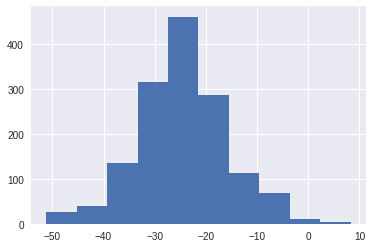

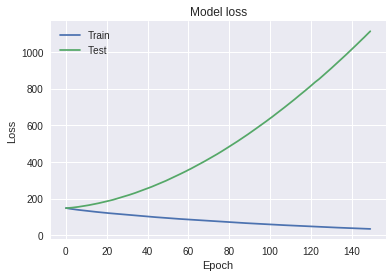

Last validation loss :  1112.9258842468262  | last training loss :  34.079293978268694


In [0]:
models = []
models.append(test_model('mse', 'adam', None, X_tr, y_tr, X_val, y_val))

We can notice overfitting  since training loss is reducing with each epoch yet the validation loss is increasing. Adding regularization should help.

### Default linear regression without regularization and no artificial variables with Adam optimizer with default values with Mean Absolute Error (MAE) as loss


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
[[397.33682]
 [332.8573 ]
 [371.8984 ]
 ...
 [371.20663]
 [290.55554]
 [393.84778]]


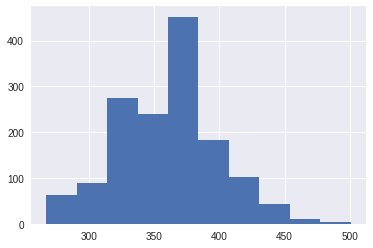

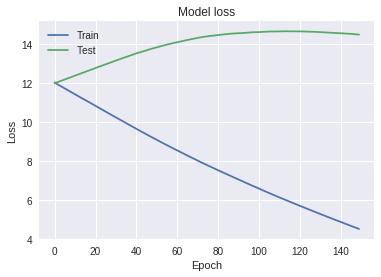

Last validation loss :  14.502253762336627  | last training loss :  4.506522122910034


In [0]:
models.append(test_model('mae', 'adam', None, X_tr, y_tr, X_val, y_val))

### Default linear regression without regularization and no artificial variables with Adam optimizer with default values with Mean Absolute Percentage Error(mape) as loss


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
[[278.70987]
 [264.8205 ]
 [279.06107]
 ...
 [272.58716]
 [257.18332]
 [283.08252]]


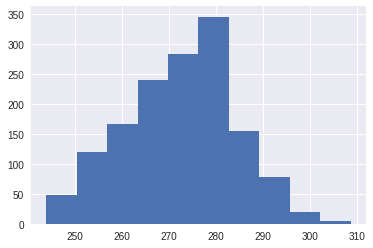

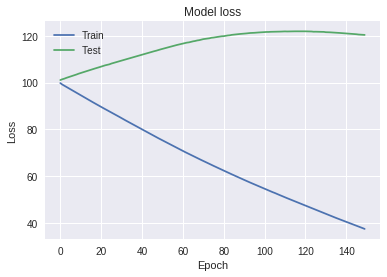

Last validation loss :  120.38922112869889  | last training loss :  37.490189208287624


In [0]:
models.append(test_model('mean_absolute_percentage_error', 'adam', None, X_tr, y_tr, X_val, y_val))

### Linear regression with L1 regularization(0.2) and no artificial variables with Adam optimizer with default values with mse as loss


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
[[5.6198516]
 [3.7415018]
 [5.3771353]
 ...
 [5.4360933]
 [1.6542253]
 [5.430674 ]]


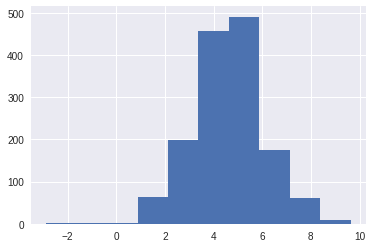

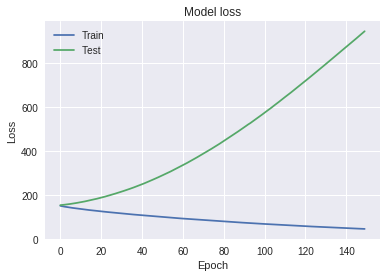

Last validation loss :  946.8578281977406  | last training loss :  45.04352016361881


In [0]:
models.append(test_model('mse', 'adam', l1(0.2), X_tr, y_tr, X_val, y_val))

We can notice improvement but not enough, we need to increase the regularization factor.

### Linear regression with L1 regularization(0.5) and no artificial variables with Adam optimizer with default values with mse as loss


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
[[13.9598465]
 [13.693564 ]
 [14.179237 ]
 ...
 [13.918031 ]
 [13.659154 ]
 [14.265289 ]]


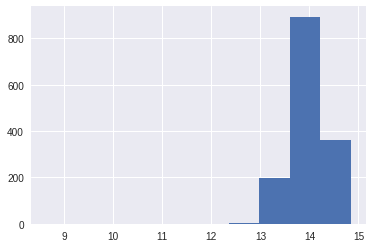

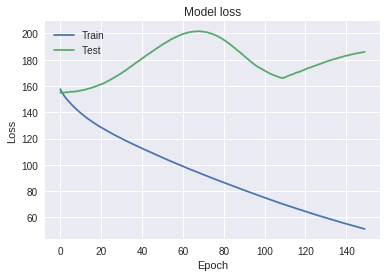

Last validation loss :  185.9379864313831  | last training loss :  51.23050703632233


In [0]:
models.append(test_model('mse', 'adam', l1(0.5), X_tr, y_tr, X_val, y_val))

### Linear regression with L1 regularization(1) and no artificial variables with Adam optimizer with default values with mse as loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
[[13.467463 ]
 [13.258734 ]
 [13.475121 ]
 ...
 [13.402283 ]
 [13.150951 ]
 [13.5473385]]


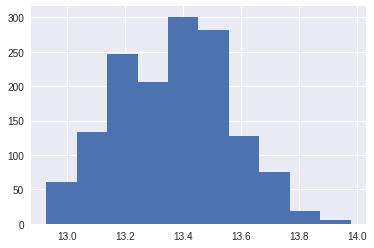

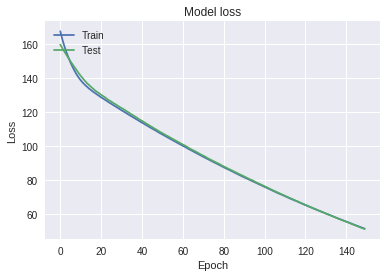

Last validation loss :  51.39829907351977  | last training loss :  51.534420232903464


In [0]:
models.append(test_model('mse', 'adam', l1(1), X_tr, y_tr, X_val, y_val))

No overfitting, we reach our best performance, but we still haven’t reached the convergence point, raising our learning rate should do the trick.

### Linear regression with L1 regularization(1) and no artificial variables with Adam optimizer with default values with mae as loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
[[6.5516734]
 [6.5663366]
 [6.57644  ]
 ...
 [6.5552993]
 [6.582098 ]
 [6.564318 ]]


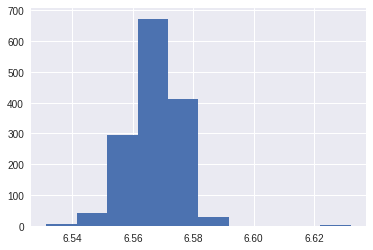

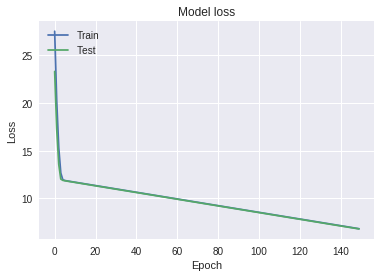

Last validation loss :  6.813851689639157  | last training loss :  6.833714407655202


In [0]:
models.append(test_model('mae', 'adam', l1(1), X_tr, y_tr, X_val, y_val))

### Linear regression with L1 regularization(1) and no artificial variables with Adam optimizer with default values with mape as loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
[[7.9987454]
 [8.031863 ]
 [8.064774 ]
 ...
 [8.022816 ]
 [8.100071 ]
 [8.054043 ]]


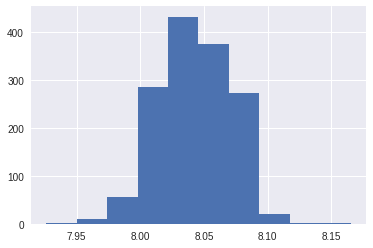

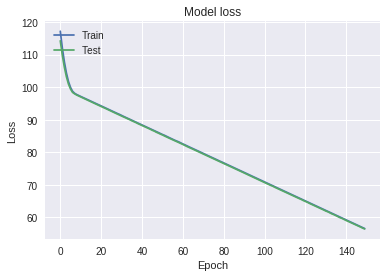

Last validation loss :  56.49328170149294  | last training loss :  56.60707485947979


In [0]:
models.append(test_model('mean_absolute_percentage_error', 'adam', l1(1), X_tr, y_tr, X_val, y_val))

### Linear regression with L1 regularization(1) and no artificial variables with SGD optimizer with default values(learning rate of 0.01 as opposed to adam default learning rate of 0.001) with mse as loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
[[56.945766]
 [56.629005]
 [57.527443]
 ...
 [57.082664]
 [56.871067]
 [57.74497 ]]


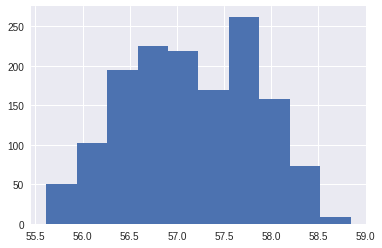

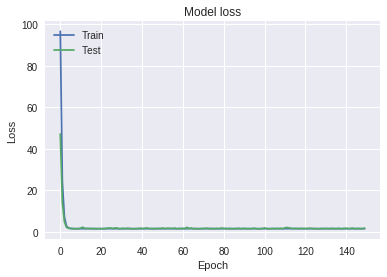

Last validation loss :  1.8619970409837487  | last training loss :  1.6212638653576645


In [0]:
models.append(test_model('mse', 'sgd', l1(1), X_tr, y_tr, X_val, y_val))

### Linear regression with L1 regularization(1) and no artificial variables with RmsProp optimizer with 0.001 learning rate with mse as loss


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
[[34.417942]
 [33.16653 ]
 [34.237743]
 ...
 [34.088097]
 [32.649597]
 [34.62783 ]]


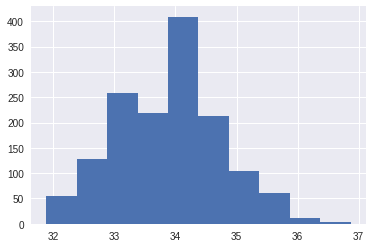

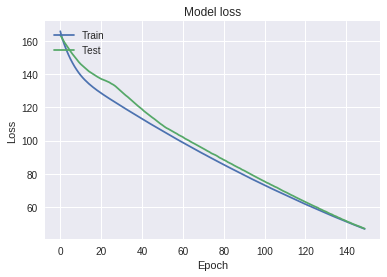

Last validation loss :  46.81881125463198  | last training loss :  46.63905477654444


In [0]:
models.append(test_model('mse', 'RMSprop', l1(1), X_tr, y_tr, X_val, y_val))

### Linear regression with L1 regularization(1) and no artificial variables with Adam optimizer with 0.005 learning rate with mse as loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
[[12.9370985]
 [12.45585  ]
 [12.682587 ]
 ...
 [12.806093 ]
 [12.11461  ]
 [12.881888 ]]


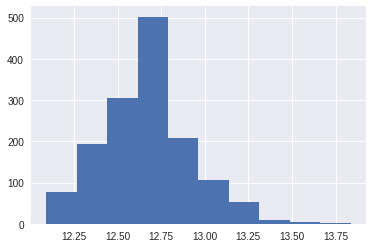

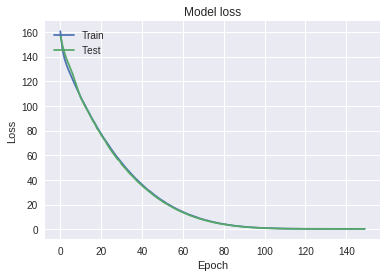

Last validation loss :  0.3107090945929697  | last training loss :  0.33341613512605295


In [0]:
models.append(test_model('mse', Adam(lr = 0.005), l1(1), X_tr, y_tr, X_val, y_val))

### Linear regression with L1 regularization(1) and no artificial variables with SGD optimizer with 0.001 learning rate with mse as loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_15 (Dense)             (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
[[6.6653395]
 [6.7970037]
 [6.683477 ]
 ...
 [6.6812315]
 [6.84391  ]
 [6.6478715]]


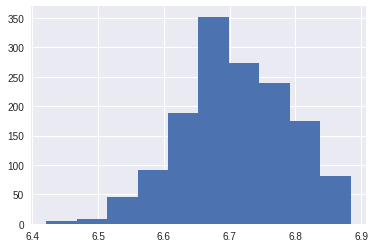

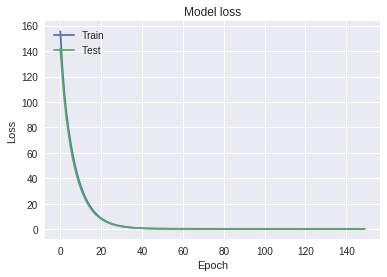

Last validation loss :  0.2849463534681764  | last training loss :  0.309956223357758


In [0]:
models.append(test_model('mse', SGD(lr=0.001), l1(1), X_tr, y_tr, X_val, y_val))

### Linear regression with L1 regularization(0.1) and no artificial variables with SGD optimizer with 0.001 learning rate with mse as loss

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_44 (Dense)             (None, 1)                 289       
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________
[[121.862854]
 [120.260025]
 [122.94467 ]
 ...
 [122.02832 ]
 [120.610535]
 [123.71791 ]]


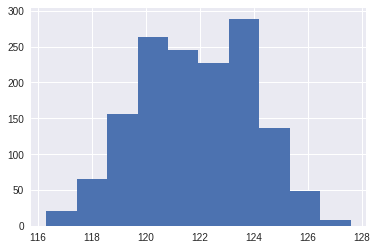

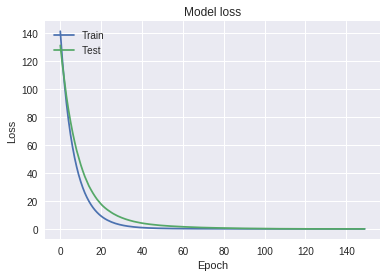

Last validation loss :  0.07051887214183808  | last training loss :  0.07267319663474549


In [0]:
models.append(test_model('mse', SGD(lr=0.001), l1(0.1), X_tr, y_tr, X_val, y_val))

---
# Conclusion
* Different losses didn’t do that much effect, but we can notice that mean absolute error helps prevents massive overfitting to some extent.
* Regularization is a must to achieve good performances on the validation set due to the model having high variance when trained without it.
* Different optimizers would affect when the model converges, however it is more important to tune their learning rate because as noticed, If tuned correctly, they will give similar convergence, however for our problem SGD was the best optimizer.
---


In [0]:
best_model = models[-1]